In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] ='false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import jax.numpy as jnp
from jax import lax
from jax import random
from flax import linen as nn
import jax
import jax.numpy as jnp
test = jnp.zeros((1,1))

import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
import os
from PIL import Image
from scipy import optimize
import scipy.signal as sp
import sdc_config5 as sdc
import wandb
from ipywidgets import IntProgress
from IPython.display import display
import sys
import time
import optax
from flax.linen import avg_pool

# define a loss function
def loss_func(U, V, meas, padded_psf_fft, filter_array, thr, xytv, lamtv):
    xk = reconstruct_xk(U, V)  # Reconstruct xk from U and V
    # calculate the forward model
    sim_meas = sdc.jax_forward_model(xk, filter_array, padded_psf_fft)
    dlam = jnp.gradient(U, axis=0)
    ddlam = jnp.gradient(dlam, axis=0)
    lamtv_loss = jnp.linalg.norm(ddlam,1)
    data_loss = jnp.linalg.norm((sim_meas - meas).ravel(),2)**2
    dy, dx = jnp.gradient(xk, axis=(-1,-2))
    tv_loss = jnp.linalg.norm(dx.ravel(),1) + jnp.linalg.norm(dy.ravel(),1)
    sparsity_loss = jnp.linalg.norm(V.ravel(),1)
    loss = data_loss + lamtv*lamtv_loss + xytv*tv_loss+ thr*sparsity_loss#+ xytv*tv_loss + lamtv*lamtv_loss 
    return loss

def reconstruct_xk(U, V):
    return (U@V).reshape(W, Y, X) # Assuming dot product performs the necessary broadcasting

def select_and_average_bands(data_cube, wavelengths, spectral_ranges):
    averaged_bands = []
    for spectral_range in spectral_ranges:
        # Find the band indices within the spectral range
        indices = np.where((wavelengths >= spectral_range[0]) & (wavelengths <= spectral_range[1]))[0]
        # Average the selected bands
        if len(indices) > 0:
            averaged_band = np.mean(data_cube[:, :, indices], axis=2)
        else:
            # If no bands fall within the range, use a dummy band of zeros
            averaged_band = np.zeros_like(data_cube[:, :, 0])
        averaged_bands.append(averaged_band)
    # Stack the averaged bands along the last dimension to form an RGB image
    rgb_image = np.stack(averaged_bands, axis=-1)
    return rgb_image

def color_visualize(image, wavelengths, title='', figsize=(10,10)):
    # Spectral ranges for averaging (in nm) for Blue, Green, Red channels
    spectral_ranges = [(450, 495), (495, 570), (620, 750)]

    # Select and average the bands
    rgb_image = select_and_average_bands(image, wavelengths, spectral_ranges)

    # Normalize the RGB image to enhance contrast if necessary
    rgb_image = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image))

    # Display the image
    plt.figure(figsize=(15, 15))
    plt.imshow(rgb_image)
    plt.title('False Color RGB Visualization with Averaged Bands')
    plt.axis('off')  # Hide axes for better visualization
    plt.show()

def wandb_log_meas(wandb_log, meas):
    # plot the lenslet positions
    fig, ax = plt.subplots(figsize=(10,10))
    # plot the measurement
    ax.imshow(meas, cmap='gray', vmin=0, vmax=1)
    # turn off the axis
    ax.axis('off')
    # add plot to log dictionary
    wandb_log['experimental_measurement'] = fig
    # close the figure
    plt.close()
    return wandb_log

def wandb_log_sim_meas(wandb_log, meas):
    # make the graph
    fig, ax = plt.subplots(figsize=(10,10))
    # plot the measurement
    ax.imshow(meas, cmap='gray', vmin=0, vmax=1)
    # turn off the axis
    ax.axis('off')
    # add plot to log dictionary
    wandb_log['simulated_measurement'] = fig
    # close the figure
    plt.close()
    return wandb_log

def wandb_log_false_color_recon(wandb_log, recon, wavelengths):
    # Create false color filter
    HSI_data = jnp.transpose(recon, (1, 2, 0))
    HSI_data = jnp.reshape(HSI_data, [-1, recon.shape[0]])
    false_color_image = sdc.HSI2RGB_jax(wavelengths, HSI_data , recon.shape[1], recon.shape[2], 65, False)

    # make the graph
    fig, ax = plt.subplots(figsize=(10,10))
    # plot the false color recon
    ax.imshow(false_color_image**.9)
    # ax.imshow(false_color_image)
    # turn off the axis
    ax.axis('off')
    # add plot to log dictionary
    wandb_log['false_color_recon'] = fig
    # close the figure
    plt.close()
    return wandb_log

def wandb_log_psf(wandb_log, psf):
    # make the graph
    fig, ax = plt.subplots(figsize=(10,10))
    # plot the psf
    ax.imshow(psf, cmap='gray')
    # turn off the axis
    ax.axis('off')
    # add plot to log dictionary
    wandb_log['psf'] = fig
    # close the figure
    plt.close()
    return wandb_log

def wandb_log_ground_truth(wandb_log, gt):
    
    # make the graph
    fig, ax = plt.subplots(figsize=(10,10))
    # plot the psf
    if gt.shape[-1]!=3:
        ax.imshow(gt, cmap='gray')
    else:
        ax.imshow(gt)
    # turn off the axis
    ax.axis('off')
    # add plot to log dictionary
    wandb_log['ground_truth'] = fig
    # close the figure
    plt.close()
    return wandb_log


In [2]:
torch.load('/home/neerja/CODE/SpectralDiffuserScopeGitRepo/JaxCode/Results/drying_beads_drop2/drying_beads_meas0000_low_rank.pt')

Array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

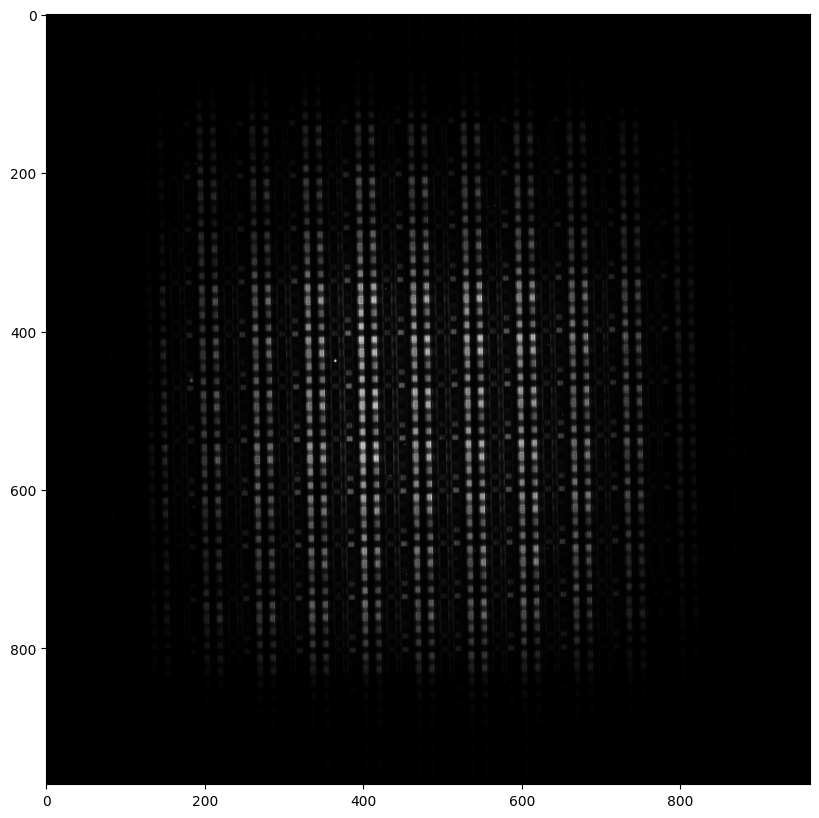

torch.Size([972, 964])

In [6]:
calibration_location = 'recon_materials_organized'
psf_name = 'psf_2024-01-30.pt'
calibration_wavelengths_file = 'neerja_waves_march_2024.npy'
filter_cube_file = 'neerja_filter_march_2024.npy'

datafolder = '/media/azuldata/neerja/2024-02-08_usaf/usaf_10x'
# datafolder = '/media/azuldata/neerja/2024-01-30/lily_pollen'
datafolder = '/media/azuldata/neerja/2024-01-30/multicolor_10umgreen_30umorange'
# datafolder = '/media/azuldata/neerja/2024-02-01/drying_beads_drop/meas0000'
datafolder = '/media/azuldata/neerja/2024-03-06_usaf/usaf_4x_cropped'
ground_truth_spectra_locs = ['/media/azuldata/neerja/2022-04-08/greenbeads_oldslide_emissionspectra.csv', 
                            '/media/azuldata/neerja/2022-04-08/redbeads_fresh_emissionspectra.csv']
bits = 16
gpu = 1
crop_indices = [680,1652,1600,2564]
wvmin = 450
wvmax = 800
wvstep = 6
downsample_factor = 2
sample = datafolder.split('/')[-1]
kmax = 3000
step_size = 5e-2
thr = 6e-5 #3e-6
xytv = 1e-6 
lamtv = 1e-6 #2e-6
low_rank_thr = 1e-2
kprint = 100
dict_learn = False
filter_scale = 1

# kmax = 4000
# step_size = 1e-2
# thr = 3e-5 #3e-6
# xytv = 1e-6 
# lamtv = 1e-6 #2e-6
# kprint = 100
# %matplotlib inline
# bits = 16


# ACTION: CHOOSE WHICH GPU TO USE (0-3)
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

# ACTION: CHOOSE WHICH GPU TO USE (0-3)
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)


# run_name = sample + '_thr={}_xytv={}_lamtv={}_kmax={}_stepsize={}_downsample={}_fitler_scale={}'.format(thr, xytv, lamtv, kmax, step_size, downsample_factor, filter_scale)

run_name = sample + '_low_rank_filter_new_vis'
# load the measurement and display it to make sure your crop indices are correct

# Uncomment this line to load from a folder of measurements to average over
# Uncomment this line to load from a single measurement 
try:
    sample_meas = sdc.importTiff(datafolder,'meas.tiff')/(2**bits-1)
except:
    sample_meas = torch.mean(sdc.tif_loader(os.path.join(datafolder,'measurements'))/(2**bits-1),0)
try:
    background = sdc.importTiff(datafolder,'bg.tiff')/2**bits
except:
    print('No background image found, continuing without background subtraction')
    background = torch.zeros(sample_meas.shape)
meas = sdc.cropci((sample_meas-background).clip(0,1),crop_indices)
meas = meas/meas.max()
sdc.bw_visualize(meas)
meas.shape

In [7]:
# ACTION: CHOOSE WHICH GPU TO USE (0-3)
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

# ACTION: CHOOSE WHICH GPU TO USE (0-3)
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)

# # Set up waits and biases run
wandb.init(
    # Set the project where this run will be logged
    project='HyperSpectralDiffuserScope', 
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=run_name,
    # Track hyperparameters and run metadata
    config={"wvmin": wvmin,
            "wvmax": wvmax,
            "wvstep": wvstep,
            "kmax": kmax,
            "step_size": step_size,
            "thr": thr,
            "xytv": xytv,
            "lamtv": lamtv,
            "low_rank_thr": low_rank_thr,
            "kprint": kprint,
            "dict_learn": dict_learn,
            "downsample_factor": downsample_factor,
            "sample": sample,
            "gpu": gpu}
)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


data_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
data_loss,12.09037
loss,14.04139


In [8]:
device = 'cpu'

# Load wavelength calibration and downsample to spectral resolution of filter cube
try:
    wv = torch.load(os.path.join(calibration_location, calibration_wavelengths_file),map_location='cpu')
except:
    wv = np.load(os.path.join(calibration_location, calibration_wavelengths_file))
    wv = torch.tensor(wv)
wavelengths = np.arange(wvmin,wvmax+wvstep,wvstep)

# Load and crop filter cube
try:
    normalized_filter_cube = torch.load(os.path.join(calibration_location,filter_cube_file),map_location='cpu')
except:
    normalized_filter_cube = np.load(os.path.join(calibration_location,filter_cube_file))
    normalized_filter_cube = torch.tensor(normalized_filter_cube)
filterstack = sdc.cropci(normalized_filter_cube, crop_indices)
msum = sdc.sumFilterArray(filterstack,wv,wvmin,wvmax,wvstep)
spectral_filter = msum/torch.amax(msum)
# spectral_filter = spectral_filter - torch.amin(spectral_filter,0,keepdim=True)[0]

# Load and crop PSF
sensor_psf = torch.load(os.path.join(calibration_location, psf_name),map_location='cpu')
ccrop = torchvision.transforms.CenterCrop(spectral_filter.shape[1:])
psf = ccrop(sensor_psf)
psf = psf/torch.sum(psf)
psf = psf.clip(0)

# Load measurement


# Load ground truth image
try:
    gt = sdc.importTiff(datafolder,'gt.tiff')
    if gt.shape[-1]!=3:
        gt = gt/2**bits
        gt = torchvision.transforms.functional.rotate(gt.unsqueeze(0),-90).squeeze()
    gt = gt/torch.max(gt)
except:
    print('No ground truth image found, continuing without ground truth')
    gt = torch.zeros(meas.shape)

# Load ground truth spectra
legend = []
spectra = []
for loc in ground_truth_spectra_locs:
    gt_wv,gt_int = sdc.loadspectrum(loc)
    gt_int = np.interp(wavelengths,gt_wv,gt_int)
    gt_int = gt_int/np.max(gt_int)
    gt_int = torch.tensor(gt_int).to(device)
    spectra.append(gt_int)
    legend.append(loc.split('/')[-1].split('.')[0].split('_')[0])


# Downsample and move everything to GPU
m = avg_pool(jnp.array(spectral_filter)[...,None], (downsample_factor,downsample_factor), (downsample_factor,downsample_factor), 'VALID').squeeze()
psf = avg_pool(jnp.array(psf)[None,...,None], (downsample_factor,downsample_factor), (downsample_factor,downsample_factor), 'VALID').squeeze()
meas = avg_pool(jnp.array(meas)[None,...,None], (downsample_factor,downsample_factor), (downsample_factor,downsample_factor), 'VALID').squeeze()
gt = gt.to(device)
# meas_mask = jnp.sum(m,0)>3
# m = m*meas_mask[None,...]
# meas = meas*meas_mask

xk = jnp.zeros(m.shape)
padding = ((0,0,0),(np.ceil(xk.shape[1]/2).astype(int),np.floor(xk.shape[1]/2).astype(int),0),(np.ceil(xk.shape[2]/2).astype(int),np.floor(xk.shape[2]/2).astype(int),0))
hpad = jax.lax.pad(psf[None,...], 0.0, padding).squeeze()
hfftpad = jnp.fft.fft2(hpad)

# calculate the adjoint
xk = sdc.jax_adjoint_model(meas, m, hfftpad, padding)

# initialize the optimizer
optimizer = optax.adam(learning_rate=step_size, b1=0.9, b2=0.999)

# Reshape xk for SVD
W = xk.shape[0]
X = xk.shape[2]
Y = xk.shape[1]
xk_reshaped = xk.reshape(xk.shape[0], -1)  # Shape (Lambda, X*Y)

# Perform SVD
Rank = 3
U, S, VT = jnp.linalg.svd(xk_reshaped, full_matrices=False)

# Keep only the first Rank components
U = U[:, :Rank]
S = S[:Rank]
VT = VT[:Rank, :]

# Compute initial V from S and VT
V = jnp.diag(S) @ VT  # Shape (Rank, X*Y)

# Initialize optimizer states for U and V separately
opt_state_U = optimizer.init(U)
opt_state_V = optimizer.init(V)


# define a function to calculate the gradient and return the loss
loss_and_grad = jax.jit(jax.value_and_grad(loss_func, (0,1)))
loss_list = []


# run a training loop with a progress bar
for k in range(kmax):
    wandb_log = {}
    if k == 0:
        wandb_log = wandb_log_meas(wandb_log, meas)
        wandb_log = wandb_log_psf(wandb_log, psf)
        wandb_log = wandb_log_ground_truth(wandb_log, gt)

    if k % kprint == 0:
        xk = reconstruct_xk(U, V)
        wandb_log = wandb_log_sim_meas(wandb_log, sdc.jax_forward_model(xk, m**filter_scale, hfftpad))
        wandb_log = wandb_log_false_color_recon(wandb_log, xk/jnp.max(xk)*jnp.sum(xk,0)[None,...], wavelengths)
        # wandb_log_false_color_recon(wandb_log, (xk/jnp.max(xk)*jnp.sum(xk,0)[None,...]).transpose(1,2,0), wavelengths)
        # save xk
        torch.save(xk, os.path.join('EricResults', run_name+'.pt'))

    # calculate the loss and the gradient
    loss, (grad_U, grad_V) = loss_and_grad(U, V, meas, hfftpad, m, thr, xytv, lamtv)
    loss_list.append(loss)


    # log the mse of the measurement and simulated measurement
    wandb_log['data_loss'] = jnp.linalg.norm((sdc.jax_forward_model(reconstruct_xk(U,V), m, hfftpad) - meas).ravel(),2)**2

    # log the custom loss
    wandb_log['loss'] = loss

    # Update U and V using their respective gradients
    updates_U, opt_state_U = optimizer.update(grad_U, opt_state_U, U)
    updates_V, opt_state_V = optimizer.update(grad_V, opt_state_V, V)
    updates_U = jnp.nan_to_num(updates_U)
    updates_V = jnp.nan_to_num(updates_V)
    U = optax.apply_updates(U, updates_U)
    V = optax.apply_updates(V, updates_V)
    U = jnp.clip(U, 0, None)
    V = jnp.clip(V, 0, None)

    wandb.log(wandb_log)

806
